In [1]:
# !pip uninstall numpy pandas
# !pip install --upgrade numpy
# !pip install --upgrade pandas

In [2]:
# ═════════════════════════════════════════
# 🚀 1. INSTALL DEPENDENCIES
# ═════════════════════════════════════════
!pip install speechbrain datasets[audio] librosa audiomentations --quiet
!pip install datasets torchaudio librosa torch pandas scikit-learn tqdm matplotlib --quiet # this line will upgrade pandas

In [17]:
# ═════════════════════════════════════════
# 📥 2. IMPORTS
# ═════════════════════════════════════════
import torchaudio
from datasets import load_dataset
import torch.nn.functional as F
from speechbrain.lobes.models.Xvector import Xvector
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import torch, librosa, numpy as np
import os
from datasets import Audio
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [4]:
# ────────────────────────────────────────────────────────────────────────────────
# 📂 3. LOAD DATASET & ADD LABELS
# ────────────────────────────────────────────────────────────────────────────────
# Load all 1,662 examples in a single Dataset split (no built-in 'train' key) :contentReference[oaicite:1]{index=1}
ds = load_dataset("birgermoell/Italian_Parkinsons_Voice_and_Speech", split="train")

# Extract file paths and derive binary labels (0=healthy, 1=parkinson) from folder names :contentReference[oaicite:2]{index=2}
file_paths = [ex["audio"]["path"] for ex in ds]
labels     = [0 if "Healthy Control" in p else 1 for p in file_paths]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/833 [00:00<?, ?it/s]

B1LBULCAAS94M100120171056.wav:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

B2LBULCAAS94M100120171015.wav:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171015..wav:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171017.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

B2LBULCAAS94M100120171056.wav:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

B1LBULCAAS94M100120171057.wav:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

B1AMULCAAS94M100120171016.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

B1LBULCAAS94M100120171015.wav:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

B1LBULCAAS94M100120171017.wav:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171056.wav:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171016.wav:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171053.wav:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

B2LBULCAAS94M100120171016.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

B2LBULCAAS94M100120171017.wav:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

B2LBULCAAS94M100120171057.wav:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

PR11LBULCAAS94M100120171057.wav:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

B2LBULCAAS94M100120171053.wav:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

B1LBULCAAS94M100120171020.wav:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171020.wav:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

B1LBULCAAS94M100120171036.wav:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171036.wav:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

B2LBULCAAS94M100120171036.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171065.wav:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

B1LBULCAAS94M100120171064.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

B2LBULCAAS94M100120171065.wav:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

B2LBULCAAS94M100120171020.wav:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

B1LBULCAAS94M100120171053.wav:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

B1TDULCAAS94M100120171065.wav:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171064.wav:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

B1LBULCAAS94M100120171021.wav:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

B2LBULCAAS94M100120171064.wav:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

B2LBULCAAS94M100120171021.wav:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171021.wav:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

B2LBULCAAS94M100120171043.wav:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

B1LBULCAAS94M100120171043.wav:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171043.wav:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

B1LBULCAAS94M100120171063.wav:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171063.wav:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

B2LBULCAAS94M100120171023.wav:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

B1LBULCAAS94M100120171023.wav:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

B2LBULCAAS94M100120171063.wav:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171023.wav:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

B1LBULCAAS94M100120171066.wav:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

B1APGANRET55F170320171104.wav:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

PR1LBULCAAS94M100120171066.wav:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

B2APGANRET55F170320171105.wav:   0%|          | 0.00/2.49M [00:00<?, ?B/s]

D1APGANRET55F170320171106.wav:   0%|          | 0.00/217k [00:00<?, ?B/s]

D2APGANRET55F170320171107.wav:   0%|          | 0.00/246k [00:00<?, ?B/s]

PR1APGANRET55F170320171114.wav:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

VA2APGANRET55F170320171108.wav:   0%|          | 0.00/220k [00:00<?, ?B/s]

B2LBULCAAS94M100120171066.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

VI2APGANRET55F170320171110.wav:   0%|          | 0.00/208k [00:00<?, ?B/s]

VE1APGANRET55F170320171109.wav:   0%|          | 0.00/349k [00:00<?, ?B/s]

VE2APGANRET55F170320171109.wav:   0%|          | 0.00/196k [00:00<?, ?B/s]

FB1APGANRET55F170320171115.wav:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

VO1APGANRET55F170320171111.wav:   0%|          | 0.00/321k [00:00<?, ?B/s]

VU1APGANRET55F170320171112.wav:   0%|          | 0.00/333k [00:00<?, ?B/s]

VI1APGANRET55F170320171109.wav:   0%|          | 0.00/334k [00:00<?, ?B/s]

VU2APGANRET55F170320171112.wav:   0%|          | 0.00/224k [00:00<?, ?B/s]

B1ACNAGRER49F210320170916.wav:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

VO2APGANRET55F170320171111.wav:   0%|          | 0.00/224k [00:00<?, ?B/s]

B2ACNAGRER49F210320170919.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

D1ACNAGRER49F210320171134.wav:   0%|          | 0.00/211k [00:00<?, ?B/s]

D2ACNAGRER49F210320171135.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

FB1ACNAGRER49F210320170926.wav:   0%|          | 0.00/795k [00:00<?, ?B/s]

VA1ACNAGRER49F210320170920.wav:   0%|          | 0.00/372k [00:00<?, ?B/s]

VA1APGANRET55F170320171107.wav:   0%|          | 0.00/433k [00:00<?, ?B/s]

PR1ACNAGRER49F210320170925.wav:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

VA2ACNAGRER49F210320170920.wav:   0%|          | 0.00/217k [00:00<?, ?B/s]

VI1ACNAGRER49F210320170921.wav:   0%|          | 0.00/721k [00:00<?, ?B/s]

VE1ACNAGRER49F210320170921.wav:   0%|          | 0.00/540k [00:00<?, ?B/s]

VE2ACNAGRER49F210320170921.wav:   0%|          | 0.00/197k [00:00<?, ?B/s]

VI2ACNAGRER49F210320170922.wav:   0%|          | 0.00/206k [00:00<?, ?B/s]

VO1ACNAGRER49F210320170922.wav:   0%|          | 0.00/576k [00:00<?, ?B/s]

VO2ACNAGRER49F210320170923.wav:   0%|          | 0.00/226k [00:00<?, ?B/s]

VU2ACNAGRER49F210320170923.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

VU1ACNAGRER49F210320170923.wav:   0%|          | 0.00/658k [00:00<?, ?B/s]

B1AGNIGNEE54F230320171018.wav:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

B2AGNIGNEE54F230320171019.wav:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

D2AGNIGNEE54F230320171020.wav:   0%|          | 0.00/233k [00:00<?, ?B/s]

PR1AGNIGNEE54F230320171024.wav:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

FB1AGNIGNEE54F230320171025.wav:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

VA2AGNIGNEE54F230320171021.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

VE1AGNIGNEE54F230320171021.wav:   0%|          | 0.00/258k [00:00<?, ?B/s]

VE2AGNIGNEE54F230320171021.wav:   0%|          | 0.00/231k [00:00<?, ?B/s]

VI2AGNIGNEE54F230320171022.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VO1AGNIGNEE54F230320171022.wav:   0%|          | 0.00/286k [00:00<?, ?B/s]

VO2AGNIGNEE54F230320171022.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VU1AGNIGNEE54F230320171022.wav:   0%|          | 0.00/400k [00:00<?, ?B/s]

VI1AGNIGNEE54F230320171021.wav:   0%|          | 0.00/279k [00:00<?, ?B/s]

VU2AGNIGNEE54F230320171023.wav:   0%|          | 0.00/197k [00:00<?, ?B/s]

VA1AGNIGNEE54F230320171020.wav:   0%|          | 0.00/625k [00:00<?, ?B/s]

D1APNITNOT56F230320170849.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

B1APNITNOT56F230320170847.wav:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

B2APNITNOT56F230320170849.wav:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

FB1APNITNOT56F230320170857.wav:   0%|          | 0.00/845k [00:00<?, ?B/s]

PR1APNITNOT56F230320170856.wav:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

D2APNITNOT56F230320170850.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

VE1APNITNOT56F230320170851.wav:   0%|          | 0.00/268k [00:00<?, ?B/s]

VE2APNITNOT56F230320170852.wav:   0%|          | 0.00/178k [00:00<?, ?B/s]

VI1APNITNOT56F230320170852.wav:   0%|          | 0.00/400k [00:00<?, ?B/s]

VO1APNITNOT56F230320170854.wav:   0%|          | 0.00/327k [00:00<?, ?B/s]

VI2APNITNOT56F230320170853.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VA1APNITNOT56F230320170850.wav:   0%|          | 0.00/375k [00:00<?, ?B/s]

VU1APNITNOT56F230320170855.wav:   0%|          | 0.00/333k [00:00<?, ?B/s]

VO2APNITNOT56F230320170854.wav:   0%|          | 0.00/202k [00:00<?, ?B/s]

VU2APNITNOT56F230320170855.wav:   0%|          | 0.00/218k [00:00<?, ?B/s]

D1ACNUTCOC40M230320171124.wav:   0%|          | 0.00/225k [00:00<?, ?B/s]

B1ACNUTCOC40M230320171121.wav:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

VA2APNITNOT56F230320170851.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

B2ACNUTCOC40M230320171123.wav:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

D1AGNIGNEE54F230320171019.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

FB1ACNUTCOC40M230320171130.wav:   0%|          | 0.00/912k [00:00<?, ?B/s]

D2ACNUTCOC40M230320171124.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

VA1ACNUTCOC40M230320171125.wav:   0%|          | 0.00/234k [00:00<?, ?B/s]

VA2ACNUTCOC40M230320171125.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VE1ACNUTCOC40M230320171126.wav:   0%|          | 0.00/325k [00:00<?, ?B/s]

VO2ACNUTCOC40M230320171127.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VI1ACNUTCOC40M230320171126.wav:   0%|          | 0.00/310k [00:00<?, ?B/s]

VI2ACNUTCOC40M230320171126.wav:   0%|          | 0.00/182k [00:00<?, ?B/s]

VE2ACNUTCOC40M230320171126.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

VU1ACNUTCOC40M230320171128.wav:   0%|          | 0.00/363k [00:00<?, ?B/s]

PR1ACNUTCOC40M230320171129.wav:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

VO1ACNUTCOC40M230320171127.wav:   0%|          | 0.00/338k [00:00<?, ?B/s]

VU2ACNUTCOC40M230320171128.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VE2BCRAISGS48F210320171006.wav:   0%|          | 0.00/223k [00:00<?, ?B/s]

D2BCRAISGS48F210320171005.wav:   0%|          | 0.00/205k [00:00<?, ?B/s]

VI2BCRAISGS48F210320171007.wav:   0%|          | 0.00/209k [00:00<?, ?B/s]

D1BCRAISGS48F210320171004.wav:   0%|          | 0.00/231k [00:00<?, ?B/s]

FB1BCRAISGS48F210320171013.wav:   0%|          | 0.00/798k [00:00<?, ?B/s]

PR1BCRAISGS48F210320171012.wav:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

VA1BCRAISGS48F210320171005.wav:   0%|          | 0.00/344k [00:00<?, ?B/s]

VE1BCRAISGS48F210320171006.wav:   0%|          | 0.00/379k [00:00<?, ?B/s]

B2BCRAISGS48F210320171004.wav:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

VA2BCRAISGS48F210320171005.wav:   0%|          | 0.00/205k [00:00<?, ?B/s]

B1BCRAISGS48F210320171002.wav:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

VO1BCRAISGS48F210320171007.wav:   0%|          | 0.00/393k [00:00<?, ?B/s]

VO2BCRAISGS48F210320171008.wav:   0%|          | 0.00/207k [00:00<?, ?B/s]

VU2BCRAISGS48F210320171010.wav:   0%|          | 0.00/215k [00:00<?, ?B/s]

VU1BCRAISGS48F210320171009.wav:   0%|          | 0.00/409k [00:00<?, ?B/s]

B1GCIALSDA52F170320171124.wav:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

B2GCIALSDA52F170320171125.wav:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

VI1BCRAISGS48F210320171007.wav:   0%|          | 0.00/454k [00:00<?, ?B/s]

FB1GCIALSDA52F170320171133.wav:   0%|          | 0.00/827k [00:00<?, ?B/s]

D2GCIALSDA52F170320171126.wav:   0%|          | 0.00/220k [00:00<?, ?B/s]

D1GCIALSDA52F170320171126.wav:   0%|          | 0.00/216k [00:00<?, ?B/s]

VA2GCIALSDA52F170320171127.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

PR1GCIALSDA52F170320171132.wav:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

VA1GCIALSDA52F170320171127.wav:   0%|          | 0.00/357k [00:00<?, ?B/s]

VE2GCIALSDA52F170320171128.wav:   0%|          | 0.00/196k [00:00<?, ?B/s]

VE1GCIALSDA52F170320171127.wav:   0%|          | 0.00/507k [00:00<?, ?B/s]

VI2GCIALSDA52F170320171129.wav:   0%|          | 0.00/200k [00:00<?, ?B/s]

VI1GCIALSDA52F170320171128.wav:   0%|          | 0.00/526k [00:00<?, ?B/s]

VO1GCIALSDA52F170320171129.wav:   0%|          | 0.00/353k [00:00<?, ?B/s]

VO2GCIALSDA52F170320171130.wav:   0%|          | 0.00/217k [00:00<?, ?B/s]

VU1GCIALSDA52F170320171130.wav:   0%|          | 0.00/333k [00:00<?, ?B/s]

B1GGIAORVG47F300320171207.wav:   0%|          | 0.00/4.78M [00:00<?, ?B/s]

B2GGIAORVG47F300320171210.wav:   0%|          | 0.00/3.40M [00:00<?, ?B/s]

D1GGIAORVG47F300320171212.wav:   0%|          | 0.00/199k [00:00<?, ?B/s]

VU2GCIALSDA52F170320171130.wav:   0%|          | 0.00/216k [00:00<?, ?B/s]

D2GGIAORVG47F300320171212.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

PR1GGIAORVG47F300320171217.wav:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

FB1GGIAORVG47F300320171218.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

VA1GGIAORVG47F300320171212.wav:   0%|          | 0.00/392k [00:00<?, ?B/s]

VA2GGIAORVG47F300320171213.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VE2GGIAORVG47F300320171214.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VE1GGIAORVG47F300320171213.wav:   0%|          | 0.00/264k [00:00<?, ?B/s]

VI1GGIAORVG47F300320171214.wav:   0%|          | 0.00/334k [00:00<?, ?B/s]

VI2GGIAORVG47F300320171214.wav:   0%|          | 0.00/227k [00:00<?, ?B/s]

VO1GGIAORVG47F300320171214.wav:   0%|          | 0.00/312k [00:00<?, ?B/s]

VO2GGIAORVG47F300320171215.wav:   0%|          | 0.00/211k [00:00<?, ?B/s]

B1GBIAORVI48M230320171233.wav:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

VU2GGIAORVG47F300320171215.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

B2GBIAORVI48M230320171234.wav:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

D2GBIAORVI48M230320171235.wav:   0%|          | 0.00/196k [00:00<?, ?B/s]

PR1GBIAORVI48M230320171240.wav:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

FB1GBIAORVI48M230320171241.wav:   0%|          | 0.00/875k [00:00<?, ?B/s]

D1GBIAORVI48M230320171235.wav:   0%|          | 0.00/222k [00:00<?, ?B/s]

VU1GGIAORVG47F300320171215.wav:   0%|          | 0.00/429k [00:00<?, ?B/s]

VE2GBIAORVI48M230320171237.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VE1GBIAORVI48M230320171236.wav:   0%|          | 0.00/395k [00:00<?, ?B/s]

VI1GBIAORVI48M230320171237.wav:   0%|          | 0.00/509k [00:00<?, ?B/s]

VI2GBIAORVI48M230320171238.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VO1GBIAORVI48M230320171238.wav:   0%|          | 0.00/463k [00:00<?, ?B/s]

VO2GBIAORVI48M230320171239.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

VA1GBIAORVI48M230320171236.wav:   0%|          | 0.00/533k [00:00<?, ?B/s]

VU1GBIAORVI48M230320171239.wav:   0%|          | 0.00/536k [00:00<?, ?B/s]

VU2GBIAORVI48M230320171239.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

B2GGRIAUZL45F020420171820.wav:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

D2GGRIAUZL45F020420171820.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

FB1GGRIAUZL45F020420171827.wav:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

VA2GBIAORVI48M230320171236.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

VA2GGRIAUZL45F020420171821.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

PR1GGRIAUZL45F020420171826.wav:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

B1GGRIAUZL45F020420171817.wav:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

VE1GGRIAUZL45F020420171822.wav:   0%|          | 0.00/273k [00:00<?, ?B/s]

VI1GGRIAUZL45F020420171822.wav:   0%|          | 0.00/330k [00:00<?, ?B/s]

VE2GGRIAUZL45F020420171822.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VA1GGRIAUZL45F020420171821.wav:   0%|          | 0.00/186k [00:00<?, ?B/s]

VI2GGRIAUZL45F020420171823.wav:   0%|          | 0.00/190k [00:00<?, ?B/s]

VO1GGRIAUZL45F020420171823.wav:   0%|          | 0.00/347k [00:00<?, ?B/s]

D1LFEIOONR57F210320171125.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

FB1LFEIOONR57F210320171131.wav:   0%|          | 0.00/958k [00:00<?, ?B/s]

B2LFEIOONR57F210320171124.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

VO2GGRIAUZL45F020420171823.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

B1LFEIOONR57F210320171120.wav:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

PR1LFEIOONR57F210320171130.wav:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

VU1GGRIAUZL45F020420171824.wav:   0%|          | 0.00/306k [00:00<?, ?B/s]

D2LFEIOONR57F210320171125.wav:   0%|          | 0.00/203k [00:00<?, ?B/s]

VA2LFEIOONR57F210320171126.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

VE2LFEIOONR57F210320171127.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

VE1LFEIOONR57F210320171126.wav:   0%|          | 0.00/329k [00:00<?, ?B/s]

D1GGRIAUZL45F020420171820.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

VA1LFEIOONR57F210320171126.wav:   0%|          | 0.00/260k [00:00<?, ?B/s]

VI1LFEIOONR57F210320171127.wav:   0%|          | 0.00/396k [00:00<?, ?B/s]

B2GLIIUSSC57M210320171051.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

VI2LFEIOONR57F210320171127.wav:   0%|          | 0.00/214k [00:00<?, ?B/s]

VU1LFEIOONR57F210320171128.wav:   0%|          | 0.00/528k [00:00<?, ?B/s]

VO2LFEIOONR57F210320171128.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

FB1GLIIUSSC57M210320171058.wav:   0%|          | 0.00/788k [00:00<?, ?B/s]

PR1GLIIUSSC57M210320171057.wav:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

B1GLIIUSSC57M210320171050.wav:   0%|          | 0.00/1.95M [00:00<?, ?B/s]

D2GLIIUSSC57M210320171052.wav:   0%|          | 0.00/204k [00:00<?, ?B/s]

D1GLIIUSSC57M210320171052.wav:   0%|          | 0.00/227k [00:00<?, ?B/s]

VU2LFEIOONR57F210320171128.wav:   0%|          | 0.00/219k [00:00<?, ?B/s]

VU2GGRIAUZL45F020420171824.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VE1GLIIUSSC57M210320171053.wav:   0%|          | 0.00/708k [00:00<?, ?B/s]

VA2GLIIUSSC57M210320171053.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

VO1LFEIOONR57F210320171128.wav:   0%|          | 0.00/528k [00:00<?, ?B/s]

VA1GLIIUSSC57M210320171052.wav:   0%|          | 0.00/590k [00:00<?, ?B/s]

VU2GLIIUSSC57M210320171056.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

VU1GLIIUSSC57M210320171055.wav:   0%|          | 0.00/548k [00:00<?, ?B/s]

VE2GLIIUSSC57M210320171053.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

VI1GLIIUSSC57M210320171054.wav:   0%|          | 0.00/430k [00:00<?, ?B/s]

VI2GLIIUSSC57M210320171054.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

B2LPUUITGI41M230320171110.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

VO2GLIIUSSC57M210320171055.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

VO1GLIIUSSC57M210320171055.wav:   0%|          | 0.00/458k [00:00<?, ?B/s]

D2LPUUITGI41M230320171111.wav:   0%|          | 0.00/237k [00:00<?, ?B/s]

D1LPUUITGI41M230320171110.wav:   0%|          | 0.00/235k [00:00<?, ?B/s]

FB1LPUUITGI41M230320171116.wav:   0%|          | 0.00/986k [00:00<?, ?B/s]

VA1LPUUITGI41M230320171111.wav:   0%|          | 0.00/398k [00:00<?, ?B/s]

B1LPUUITGI41M230320171109.wav:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

VE1LPUUITGI41M230320171112.wav:   0%|          | 0.00/375k [00:00<?, ?B/s]

PR1LPUUITGI41M230320171115.wav:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

VA2LPUUITGI41M230320171111.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

VI1LPUUITGI41M230320171113.wav:   0%|          | 0.00/385k [00:00<?, ?B/s]

VE2LPUUITGI41M230320171112.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

VO1LPUUITGI41M230320171113.wav:   0%|          | 0.00/372k [00:00<?, ?B/s]

VI2LPUUITGI41M230320171113.wav:   0%|          | 0.00/197k [00:00<?, ?B/s]

VU1LPUUITGI41M230320171114.wav:   0%|          | 0.00/404k [00:00<?, ?B/s]

VO2LPUUITGI41M230320171113.wav:   0%|          | 0.00/214k [00:00<?, ?B/s]

VU2LPUUITGI41M230320171114.wav:   0%|          | 0.00/201k [00:00<?, ?B/s]

B1MPAERRIR56F300320171143.wav:   0%|          | 0.00/1.89M [00:00<?, ?B/s]

VA1MPAERRIR56F300320171146.wav:   0%|          | 0.00/246k [00:00<?, ?B/s]

B2MPAERRIR56F300320171145.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

D1MPAERRIR56F300320171145.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

PR1MPAERRIR56F300320171150.wav:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

D2MPAERRIR56F300320171145.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

VE2MPAERRIR56F300320171147.wav:   0%|          | 0.00/182k [00:00<?, ?B/s]

VI2MPAERRIR56F300320171148.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VE1MPAERRIR56F300320171147.wav:   0%|          | 0.00/400k [00:00<?, ?B/s]

VI1MPAERRIR56F300320171147.wav:   0%|          | 0.00/467k [00:00<?, ?B/s]

VU2MPAERRIR56F300320171149.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VO1MPAERRIR56F300320171148.wav:   0%|          | 0.00/425k [00:00<?, ?B/s]

VO2MPAERRIR56F300320171148.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VU1MPAERRIR56F300320171149.wav:   0%|          | 0.00/573k [00:00<?, ?B/s]

B1MGIACTHT49M210320170848.wav:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

PR1MGIACTHT49M210320170903.wav:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

B2MGIACTHT49M210320170850.wav:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

D1MGIACTHT49M210320170854.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

FB1MGIACTHT49M210320170904.wav:   0%|          | 0.00/859k [00:00<?, ?B/s]

D2MGIACTHT49M210320170855.wav:   0%|          | 0.00/218k [00:00<?, ?B/s]

VA1MGIACTHT49M210320170855.wav:   0%|          | 0.00/703k [00:00<?, ?B/s]

VA2MGIACTHT49M210320170856.wav:   0%|          | 0.00/238k [00:00<?, ?B/s]

VA2MPAERRIR56F300320171146.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VI1MGIACTHT49M210320170859.wav:   0%|          | 0.00/555k [00:00<?, ?B/s]

VI2MGIACTHT49M210320170859.wav:   0%|          | 0.00/202k [00:00<?, ?B/s]

VE2MGIACTHT49M210320170857.wav:   0%|          | 0.00/222k [00:00<?, ?B/s]

VE1MGIACTHT49M210320170856.wav:   0%|          | 0.00/667k [00:00<?, ?B/s]

VO1MGIACTHT49M210320170859.wav:   0%|          | 0.00/460k [00:00<?, ?B/s]

FB1MPAERRIR56F300320171151.wav:   0%|          | 0.00/942k [00:00<?, ?B/s]

VO2MGIACTHT49M210320170900.wav:   0%|          | 0.00/214k [00:00<?, ?B/s]

VE2NPIICEOR42M020420171810.wav:   0%|          | 0.00/197k [00:00<?, ?B/s]

VU2MGIACTHT49M210320170901.wav:   0%|          | 0.00/219k [00:00<?, ?B/s]

D2NPIICEOR42M020420171807.wav:   0%|          | 0.00/201k [00:00<?, ?B/s]

VA2NPIICEOR42M020420171809.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

FB1NPIICEOR42M020420171814.wav:   0%|          | 0.00/930k [00:00<?, ?B/s]

VE1NPIICEOR42M020420171810.wav:   0%|          | 0.00/528k [00:00<?, ?B/s]

VA1NPIICEOR42M020420171808.wav:   0%|          | 0.00/638k [00:00<?, ?B/s]

B1NPIICEOR42M020420171805.wav:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

D1NPIICEOR42M020420171807.wav:   0%|          | 0.00/218k [00:00<?, ?B/s]

B2NPIICEOR42M020420171807.wav:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

PR1NPIICEOR42M020420171813.wav:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

VU1MGIACTHT49M210320170900.wav:   0%|          | 0.00/429k [00:00<?, ?B/s]

VI1NPIICEOR42M020420171811.wav:   0%|          | 0.00/584k [00:00<?, ?B/s]

VO2NPIICEOR42M020420171811.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VI2NPIICEOR42M020420171811.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VO1NPIICEOR42M020420171811.wav:   0%|          | 0.00/496k [00:00<?, ?B/s]

B1APNOTROC49M230320170926.wav:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

D1APNOTROC49M230320170928.wav:   0%|          | 0.00/227k [00:00<?, ?B/s]

B2APNOTROC49M230320170927.wav:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

FB1APNOTROC49M230320170934.wav:   0%|          | 0.00/764k [00:00<?, ?B/s]

VU1NPIICEOR42M020420171812.wav:   0%|          | 0.00/683k [00:00<?, ?B/s]

VU2NPIICEOR42M020420171812.wav:   0%|          | 0.00/202k [00:00<?, ?B/s]

D2APNOTROC49M230320170928.wav:   0%|          | 0.00/209k [00:00<?, ?B/s]

VA1APNOTROC49M230320170928.wav:   0%|          | 0.00/334k [00:00<?, ?B/s]

VA2APNOTROC49M230320170929.wav:   0%|          | 0.00/202k [00:00<?, ?B/s]

PR1APNOTROC49M230320170933.wav:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

VE1APNOTROC49M230320170929.wav:   0%|          | 0.00/660k [00:00<?, ?B/s]

VE2APNOTROC49M230320170930.wav:   0%|          | 0.00/202k [00:00<?, ?B/s]

VI1APNOTROC49M230320170930.wav:   0%|          | 0.00/650k [00:00<?, ?B/s]

VI2APNOTROC49M230320170930.wav:   0%|          | 0.00/209k [00:00<?, ?B/s]

B1LSUUIMGM48F230320171049.wav:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

VU1APNOTROC49M230320170932.wav:   0%|          | 0.00/576k [00:00<?, ?B/s]

B2LSUUIMGM48F230320171050.wav:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

VO1APNOTROC49M230320170931.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

D1LSUUIMGM48F230320171051.wav:   0%|          | 0.00/214k [00:00<?, ?B/s]

VU2APNOTROC49M230320170932.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

D2LSUUIMGM48F230320171051.wav:   0%|          | 0.00/205k [00:00<?, ?B/s]

VO2APNOTROC49M230320170931.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

FB1LSUUIMGM48F230320171059.wav:   0%|          | 0.00/893k [00:00<?, ?B/s]

PR1LSUUIMGM48F230320171058.wav:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

VA1LSUUIMGM48F230320171053.wav:   0%|          | 0.00/660k [00:00<?, ?B/s]

VE2LSUUIMGM48F230320171054.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

VA2LSUUIMGM48F230320171053.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VE1LSUUIMGM48F230320171054.wav:   0%|          | 0.00/674k [00:00<?, ?B/s]

VO1LSUUIMGM48F230320171056.wav:   0%|          | 0.00/797k [00:00<?, ?B/s]

VI2LSUUIMGM48F230320171055.wav:   0%|          | 0.00/206k [00:00<?, ?B/s]

VU1LSUUIMGM48F230320171057.wav:   0%|          | 0.00/665k [00:00<?, ?B/s]

VO2LSUUIMGM48F230320171056.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

B2TMEIRAEC54F230320171152.wav:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

B1TMEIRAEC54F230320171150.wav:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

D1TMEIRAEC54F230320171152.wav:   0%|          | 0.00/219k [00:00<?, ?B/s]

D2TMEIRAEC54F230320171152.wav:   0%|          | 0.00/230k [00:00<?, ?B/s]

VU2LSUUIMGM48F230320171057.wav:   0%|          | 0.00/221k [00:00<?, ?B/s]

FB1TMEIRAEC54F230320171158.wav:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

PR1TMEIRAEC54F230320171157.wav:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

VA1TMEIRAEC54F230320171153.wav:   0%|          | 0.00/251k [00:00<?, ?B/s]

VE2TMEIRAEC54F230320171154.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

VE1TMEIRAEC54F230320171154.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

VA2TMEIRAEC54F230320171153.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VI1TMEIRAEC54F230320171154.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VI2TMEIRAEC54F230320171154.wav:   0%|          | 0.00/197k [00:00<?, ?B/s]

VO2TMEIRAEC54F230320171155.wav:   0%|          | 0.00/194k [00:00<?, ?B/s]

VU2TMEIRAEC54F230320171155.wav:   0%|          | 0.00/205k [00:00<?, ?B/s]

VU1TMEIRAEC54F230320171155.wav:   0%|          | 0.00/177k [00:00<?, ?B/s]

VO1TMEIRAEC54F230320171155.wav:   0%|          | 0.00/211k [00:00<?, ?B/s]

D1VDIET%20AS47M210320170946.wav:   0%|          | 0.00/214k [00:00<?, ?B/s]

D2VDIET%20AS47M210320170946.wav:   0%|          | 0.00/242k [00:00<?, ?B/s]

PR1VDIETAS47M210320170948.wav:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

VA2VDIET%20AS47M210320170943.wav:   0%|          | 0.00/280k [00:00<?, ?B/s]

VA1VDIET%20AS47M210320170942.wav:   0%|          | 0.00/241k [00:00<?, ?B/s]

VI1LSUUIMGM48F230320171055.wav:   0%|          | 0.00/569k [00:00<?, ?B/s]

VE1VDIET%20AS47M210320170943.wav:   0%|          | 0.00/338k [00:00<?, ?B/s]

VE2VDIET%20AS47M210320170944.wav:   0%|          | 0.00/246k [00:00<?, ?B/s]

VU1VDIET%20AS47M210320170945.wav:   0%|          | 0.00/294k [00:00<?, ?B/s]

VI1VDIET%20AS47M210320170944.wav:   0%|          | 0.00/296k [00:00<?, ?B/s]

VI2VDIET%20AS47M210320170944.wav:   0%|          | 0.00/235k [00:00<?, ?B/s]

B1VAILTFOO49M230320171029.wav:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

VU2VDIET%20AS47M210320170945.wav:   0%|          | 0.00/205k [00:00<?, ?B/s]

VO2VDIET%20AS47M210320170945.wav:   0%|          | 0.00/202k [00:00<?, ?B/s]

D1VAILTFOO49M230320171030.wav:   0%|          | 0.00/222k [00:00<?, ?B/s]

VO1VDIET%20AS47M210320170945.wav:   0%|          | 0.00/429k [00:00<?, ?B/s]

B2VAILTFOO49M230320171030.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

D2VAILTFOO49M230320171031.wav:   0%|          | 0.00/210k [00:00<?, ?B/s]

FB1VAILTFOO49M230320171036.wav:   0%|          | 0.00/839k [00:00<?, ?B/s]

PR1VAILTFOO49M230320171035.wav:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

VA1VAILTFOO49M230320171031.wav:   0%|          | 0.00/355k [00:00<?, ?B/s]

VE1VAILTFOO49M230320171032.wav:   0%|          | 0.00/231k [00:00<?, ?B/s]

VA2VAILTFOO49M230320171031.wav:   0%|          | 0.00/217k [00:00<?, ?B/s]

VO1VAILTFOO49M230320171033.wav:   0%|          | 0.00/248k [00:00<?, ?B/s]

VE2VAILTFOO49M230320171032.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

VI2VAILTFOO49M230320171033.wav:   0%|          | 0.00/197k [00:00<?, ?B/s]

VO2VAILTFOO49M230320171033.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VI1VAILTFOO49M230320171032.wav:   0%|          | 0.00/338k [00:00<?, ?B/s]

VU1VAILTFOO49M230320171033.wav:   0%|          | 0.00/320k [00:00<?, ?B/s]

VU2VAILTFOO49M230320171034.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

B1VLIATFOO55M300320171237.wav:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

B2VLIATFOO55M300320171238.wav:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

FB1VLIATFOO55M300320171243.wav:   0%|          | 0.00/983k [00:00<?, ?B/s]

D2VLIATFOO55M300320171244.wav:   0%|          | 0.00/211k [00:00<?, ?B/s]

D1VLIATFOO55M300320171244.wav:   0%|          | 0.00/207k [00:00<?, ?B/s]

VA1VLIATFOO55M300320171245.wav:   0%|          | 0.00/709k [00:00<?, ?B/s]

VE1VLIATFOO55M300320171246.wav:   0%|          | 0.00/938k [00:00<?, ?B/s]

VI2VLIATFOO55M300320171247.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

PR1VLIATFOO55M300320171241.wav:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

VO1VLIATFOO55M300320171247.wav:   0%|          | 0.00/872k [00:00<?, ?B/s]

VA2VLIATFOO55M300320171245.wav:   0%|          | 0.00/198k [00:00<?, ?B/s]

VO2VLIATFOO55M300320171248.wav:   0%|          | 0.00/203k [00:00<?, ?B/s]

VE2VLIATFOO55M300320171246.wav:   0%|          | 0.00/201k [00:00<?, ?B/s]

VI1VLIATFOO55M300320171247.wav:   0%|          | 0.00/768k [00:00<?, ?B/s]

PR1cdaopmoe67M2605161916.wav:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

VU1VLIATFOO55M300320171248.wav:   0%|          | 0.00/802k [00:00<?, ?B/s]

B1cdaopmoe67M2605161902.wav:   0%|          | 0.00/6.49M [00:00<?, ?B/s]

VE1cdaopmoe67M2605161909.wav:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

VU2VLIATFOO55M300320171249.wav:   0%|          | 0.00/203k [00:00<?, ?B/s]

FB1cdaopmoe67M2605161917.wav:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

VA2cdaopmoe67M2605161907.wav:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

VA1cdaopmoe67M2605161906.wav:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

VE2cdaopmoe67M2605161909.wav:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

B2cdaopmoe67M2605161904.wav:   0%|          | 0.00/4.92M [00:00<?, ?B/s]

D2cdaopmoe67M2605161905.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

D1cdaopmoe67M2605161905.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

VI2cdaopmoe67M2605161911.wav:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

VI1cdaopmoe67M2605161910.wav:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

VO1cdaopmoe67M2605161911.wav:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

VO2cdaopmoe67M2605161912.wav:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

VU1cdaopmoe67M2605161913.wav:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

VU2cdaopmoe67M2605161913.wav:   0%|          | 0.00/1.76M [00:00<?, ?B/s]

B1cfaerlei54F2605161738.wav:   0%|          | 0.00/6.00M [00:00<?, ?B/s]

D2cfaerlei54F2605161742.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

D1cfaerlei54F2605161742.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

FB1cfaerlei54F2605161816.wav:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

VA1cfaerlei54F2605161745.wav:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

B2cfaerlei54F2605161740.wav:   0%|          | 0.00/5.03M [00:00<?, ?B/s]

PR1cfaerlei54F2605161815.wav:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

VA2cfaerlei54F2605161745.wav:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

VE1cfaerlei54F2605161747.wav:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

VE2cfaerlei54F2605161748.wav:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

VO1cfaerlei54F2605161755.wav:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

VI2cfaerlei54F2605161752.wav:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

VU1cfaerlei54F2605161808.wav:   0%|          | 0.00/939k [00:00<?, ?B/s]

VO2cfaerlei54F2605161756.wav:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

VI1cfaerlei54F2605161751.wav:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

VU2cfaerlei54F2605161810.wav:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

B2lloeroun56F2605161923.wav:   0%|          | 0.00/4.57M [00:00<?, ?B/s]

B1lloeroun56F2605161922.wav:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

D1lloeroun56F2605161924.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

D2lloeroun56F2605161924.wav:   0%|          | 0.00/441k [00:00<?, ?B/s]

FB1lloeroun56F2605161937.wav:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

PR1lloeroun56F2605161936.wav:   0%|          | 0.00/4.34M [00:00<?, ?B/s]

VE1lloeroun56F2605161927.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

VA1lloeroun56F2605161926.wav:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

VA2lloeroun56F2605161927.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

VE2lloeroun56F2605161928.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

VU1lloeroun56F2605161932.wav:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

VO2lloeroun56F2605161931.wav:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

VO1lloeroun56F2605161931.wav:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

VU2lloeroun56F2605161933.wav:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

VI1lloeroun56F2605161929.wav:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

VI2lloeroun56F2605161930.wav:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

B1rlouscsi77F2605161820.wav:   0%|          | 0.00/5.45M [00:00<?, ?B/s]

B2rlouscsi77F2605161822.wav:   0%|          | 0.00/4.71M [00:00<?, ?B/s]

D2rlouscsi77F2605161823.wav:   0%|          | 0.00/534k [00:00<?, ?B/s]

D1rlouscsi77F2605161822.wav:   0%|          | 0.00/525k [00:00<?, ?B/s]

FB1rlouscsi77F2605161834.wav:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

VE1rlouscsi77F2605161826.wav:   0%|          | 0.00/986k [00:00<?, ?B/s]

VA2rlouscsi77F2605161825.wav:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

VE2rlouscsi77F2605161826.wav:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

VA1rlouscsi77F2605161825.wav:   0%|          | 0.00/923k [00:00<?, ?B/s]

PR1rlouscsi77F2605161834.wav:   0%|          | 0.00/4.91M [00:00<?, ?B/s]

VI1rlouscsi77F2605161827.wav:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

VO2rlouscsi77F2605161829.wav:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

VI2rlouscsi77F2605161828.wav:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

VO1rlouscsi77F2605161828.wav:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

VU2rlouscsi77F2605161830.wav:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

VU1rlouscsi77F2605161830.wav:   0%|          | 0.00/988k [00:00<?, ?B/s]

B2rriovbie49M2605161842.wav:   0%|          | 0.00/5.87M [00:00<?, ?B/s]

B1rriovbie49M2605161841.wav:   0%|          | 0.00/7.73M [00:00<?, ?B/s]

D1rriovbie49M2605161843.wav:   0%|          | 0.00/530k [00:00<?, ?B/s]

D2rriovbie49M2605161843.wav:   0%|          | 0.00/530k [00:00<?, ?B/s]

FB1rriovbie49M2605161855.wav:   0%|          | 0.00/3.22M [00:00<?, ?B/s]

VA2rriovbie49M2605161845.wav:   0%|          | 0.00/786k [00:00<?, ?B/s]

PR1rriovbie49M2605161853.wav:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

VI1rriovbie49M2605161847.wav:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

VO2rriovbie49M2605161849.wav:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

VE2rriovbie49M2605161846.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

VO1rriovbie49M2605161848.wav:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

VA1rriovbie49M2605161845.wav:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

VU1rriovbie49M2605161849.wav:   0%|          | 0.00/981k [00:00<?, ?B/s]

VE1rriovbie49M2605161846.wav:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

VU2rriovbie49M2605161850.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

B2ABNINSAC46F240120171755.wav:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

B1ABNINSAC46F240120171753.wav:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

VI2rriovbie49M2605161848.wav:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

D2ABNINSAC46F240120171756.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

FB1ABNINSAC46F240120171808.wav:   0%|          | 0.00/847k [00:00<?, ?B/s]

PR1ABNINSAC46F240120171807.wav:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

VA1ABNINSAC46F240120171758.wav:   0%|          | 0.00/385k [00:00<?, ?B/s]

D1ABNINSAC46F240120171756.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

VA2ABNINSAC46F240120171759.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

VE1ABNINSAC46F240120171800.wav:   0%|          | 0.00/390k [00:00<?, ?B/s]

VE2ABNINSAC46F240120171801.wav:   0%|          | 0.00/208k [00:00<?, ?B/s]

VI1ABNINSAC46F240120171801.wav:   0%|          | 0.00/511k [00:00<?, ?B/s]

VU1ABNINSAC46F240120171804.wav:   0%|          | 0.00/479k [00:00<?, ?B/s]

VO2ABNINSAC46F240120171803.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

VI2ABNINSAC46F240120171802.wav:   0%|          | 0.00/208k [00:00<?, ?B/s]

VO1ABNINSAC46F240120171802.wav:   0%|          | 0.00/422k [00:00<?, ?B/s]

VU2ABNINSAC46F240120171804.wav:   0%|          | 0.00/216k [00:00<?, ?B/s]

B1MCIICLHL46M240120171825.wav:   0%|          | 0.00/1.75M [00:00<?, ?B/s]

B2MCIICLHL46M240120171827.wav:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

D2MCIICLHL46M240120171828.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

PR1MCIICLHL46M240120171836.wav:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

FB1MCIICLHL46M240120171837.wav:   0%|          | 0.00/825k [00:00<?, ?B/s]

VI2MCIICLHL46M240120171832.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

VA1MCIICLHL46M240120171830.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

D1MCIICLHL46M240120171828.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VE2MCIICLHL46M240120171831.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VI1MCIICLHL46M240120171831.wav:   0%|          | 0.00/671k [00:00<?, ?B/s]

VA2MCIICLHL46M240120171829.wav:   0%|          | 0.00/566k [00:00<?, ?B/s]

VO1MCIICLHL46M240120171833.wav:   0%|          | 0.00/683k [00:00<?, ?B/s]

VO2MCIICLHL46M240120171834.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

B1NSICCHOI44M240120171842.wav:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

VU2MCIICLHL46M240120171835.wav:   0%|          | 0.00/193k [00:00<?, ?B/s]

VU1MCIICLHL46M240120171834.wav:   0%|          | 0.00/707k [00:00<?, ?B/s]

VE1MCIICLHL46M240120171830.wav:   0%|          | 0.00/691k [00:00<?, ?B/s]

D1NSICCHOI44M240120171845.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

FB1NSICCHOI44M240120171852.wav:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

VA1NSICCHOI44M240120171845.wav:   0%|          | 0.00/322k [00:00<?, ?B/s]

PR1NSICCHOI44M240120171851.wav:   0%|          | 0.00/1.89M [00:00<?, ?B/s]

D2NSICCHOI44M240120171845.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VA2NSICCHOI44M240120171846.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

B2NSICCHOI44M240120171843.wav:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

VE1NSICCHOI44M240120171847.wav:   0%|          | 0.00/378k [00:00<?, ?B/s]

VI1NSICCHOI44M240120171848.wav:   0%|          | 0.00/320k [00:00<?, ?B/s]

VE2NSICCHOI44M240120171847.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VI2NSICCHOI44M240120171848.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VO1NSICCHOI44M240120171848.wav:   0%|          | 0.00/273k [00:00<?, ?B/s]

VO2NSICCHOI44M240120171849.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VU1NSICCHOI44M240120171849.wav:   0%|          | 0.00/301k [00:00<?, ?B/s]

B1RLOABREE42M240120171942.wav:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

VU2NSICCHOI44M240120171850.wav:   0%|          | 0.00/164k [00:00<?, ?B/s]

B2RLOABREE42M240120171944.wav:   0%|          | 0.00/1.95M [00:00<?, ?B/s]

FB1RLOABREE42M240120171955.wav:   0%|          | 0.00/970k [00:00<?, ?B/s]

D2RLOABREE42M240120171946.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

D1RLOABREE42M240120171944.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

PR1RLOABREE42M240120171954.wav:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

VA2RLOABREE42M240120171947.wav:   0%|          | 0.00/225k [00:00<?, ?B/s]

VA1RLOABREE42M240120171947.wav:   0%|          | 0.00/389k [00:00<?, ?B/s]

VE1RLOABREE42M240120171948.wav:   0%|          | 0.00/438k [00:00<?, ?B/s]

VE2RLOABREE42M240120171949.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VO2RLOABREE42M240120171951.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VO1RLOABREE42M240120171950.wav:   0%|          | 0.00/452k [00:00<?, ?B/s]

VI1RLOABREE42M240120171949.wav:   0%|          | 0.00/442k [00:00<?, ?B/s]

VI2RLOABREE42M240120171950.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VU1RLOABREE42M240120171951.wav:   0%|          | 0.00/454k [00:00<?, ?B/s]

VU2RLOABREE42M240120171952.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

B1RROIBVEI49M240120171859.wav:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

B2RROIBVEI49M240120171902.wav:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

PR1RROIBVEI49M240120171913.wav:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

D2RROIBVEI49M240120171903.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VA1RROIBVEI49M240120171904.wav:   0%|          | 0.00/549k [00:00<?, ?B/s]

VA2RROIBVEI49M240120171905.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VI1RROIBVEI49M240120171908.wav:   0%|          | 0.00/499k [00:00<?, ?B/s]

VI2RROIBVEI49M240120171909.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VE1RROIBVEI49M240120171906.wav:   0%|          | 0.00/542k [00:00<?, ?B/s]

D1RROIBVEI49M240120171903.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VO2RROIBVEI49M240120171910.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VO1RROIBVEI49M240120171910.wav:   0%|          | 0.00/530k [00:00<?, ?B/s]

FB1RROIBVEI49M240120171914.wav:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

VE2RROIBVEI49M240120171907.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VU1RROIBVEI49M240120171911.wav:   0%|          | 0.00/419k [00:00<?, ?B/s]

B1VSIPTIOZ46M240120171920.wav:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

B2VSIPTIOZ46M240120171922.wav:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

VU2RROIBVEI49M240120171911.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

D1VSIPTIOZ46M240120171923.wav:   0%|          | 0.00/213k [00:00<?, ?B/s]

D2VSIPTIOZ46M240120171923.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

FB1VSIPTIOZ46M240120171936.wav:   0%|          | 0.00/942k [00:00<?, ?B/s]

PR1VSIPTIOZ46M240120171935.wav:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

VA1VSIPTIOZ46M240120171924.wav:   0%|          | 0.00/623k [00:00<?, ?B/s]

VE1VSIPTIOZ46M240120171926.wav:   0%|          | 0.00/483k [00:00<?, ?B/s]

VI2VSIPTIOZ46M240120171928.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VE2VSIPTIOZ46M240120171927.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

VI1VSIPTIOZ46M240120171928.wav:   0%|          | 0.00/325k [00:00<?, ?B/s]

VO1VSIPTIOZ46M240120171929.wav:   0%|          | 0.00/389k [00:00<?, ?B/s]

VA2VSIPTIOZ46M240120171925.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

VO2VSIPTIOZ46M240120171930.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VU1VSIPTIOZ46M240120171932.wav:   0%|          | 0.00/365k [00:00<?, ?B/s]

B1AGNUTGOL52F100220171041.wav:   0%|          | 0.00/7.94M [00:00<?, ?B/s]

B2AGNUTGOL52F100220171045.wav:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

FB1AGNUTGOL52F100220171059.wav:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

VU2VSIPTIOZ46M240120171932.wav:   0%|          | 0.00/196k [00:00<?, ?B/s]

VA1AGNUTGOL52F100220171049.wav:   0%|          | 0.00/317k [00:00<?, ?B/s]

PR1AGNUTGOL52F100220171057.wav:   0%|          | 0.00/5.46M [00:00<?, ?B/s]

D2AGNUTGOL52F100220171046.wav:   0%|          | 0.00/164k [00:00<?, ?B/s]

VA2AGNUTGOL52F100220171049.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VI1AGNUTGOL52F100220171051.wav:   0%|          | 0.00/513k [00:00<?, ?B/s]

VE1AGNUTGOL52F100220171050.wav:   0%|          | 0.00/381k [00:00<?, ?B/s]

VI2AGNUTGOL63F100220171052.wav:   0%|          | 0.00/216k [00:00<?, ?B/s]

VE2AGNUTGOL52F100220171049.wav:   0%|          | 0.00/120k [00:00<?, ?B/s]

D1AGNUTGOL52F100220171046.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VO1AGNUTGOL52F100220171052.wav:   0%|          | 0.00/208k [00:00<?, ?B/s]

VO2AGNUTGOL52F100220171053.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

VU2AGNUTGOL52F100220171054.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

B1DLAARCII37F100220171111.wav:   0%|          | 0.00/5.55M [00:00<?, ?B/s]

D2DLAARCII37F100220171113.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

PR1DLAARCII37F100220171123.wav:   0%|          | 0.00/3.37M [00:00<?, ?B/s]

VU1AGNUTGOL52F100220171054.wav:   0%|          | 0.00/461k [00:00<?, ?B/s]

D1DLAARCII37F100220171113.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

VA1DLAARCII37F100220171114.wav:   0%|          | 0.00/405k [00:00<?, ?B/s]

FB1DLAARCII37F100220171125.wav:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

VE1DLAARCII37F100220171115.wav:   0%|          | 0.00/285k [00:00<?, ?B/s]

VE2DLAARCII37F100220171115.wav:   0%|          | 0.00/200k [00:00<?, ?B/s]

VI1DLAARCII37F100220171116.wav:   0%|          | 0.00/256k [00:00<?, ?B/s]

VI2DLAARCII37F100220171117.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VU1DLAARCII37F100220171119.wav:   0%|          | 0.00/433k [00:00<?, ?B/s]

VO2DLAARCII37F100220171117.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VO1DLAARCII37F100220171117.wav:   0%|          | 0.00/293k [00:00<?, ?B/s]

B2GMIAOSVI44M100220170944.wav:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

B1GMIAOSVI44M100220170942.wav:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

VU2DLAARCII37F100220171119.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VA2DLAARCII37F100220171114.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

D2GMIAOSVI44M100220170945.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

FB1GMIAOSVI44M100220170952.wav:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

D1GMIAOSVI44M100220170945.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

PR1GMIAOSVI44M100220170951.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

VE1GMIAOSVI44M100220170947.wav:   0%|          | 0.00/287k [00:00<?, ?B/s]

VA2GMIAOSVI44M100220170946.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

VI1GMIAOSVI44M100220170948.wav:   0%|          | 0.00/317k [00:00<?, ?B/s]

VE2GMIAOSVI44M100220170947.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VA1GMIAOSVI44M100220170946.wav:   0%|          | 0.00/269k [00:00<?, ?B/s]

VO2GMIAOSVI44M100220170949.wav:   0%|          | 0.00/200k [00:00<?, ?B/s]

VU1GMIAOSVI44M100220170949.wav:   0%|          | 0.00/269k [00:00<?, ?B/s]

VO1GMIAOSVI44M100220170948.wav:   0%|          | 0.00/337k [00:00<?, ?B/s]

VI2GMIAOSVI44M100220170948.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VU2GMIAOSVI44M100220170949.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

D1GNIEOGVL47M100220171215.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

PR1GNIEOGVL47M100220171226.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

VA1GNIEOGVL47M100220171216.wav:   0%|          | 0.00/590k [00:00<?, ?B/s]

FB1GNIEOGVL47M100220171227.wav:   0%|          | 0.00/929k [00:00<?, ?B/s]

B1GNIEOGVL47M100220171213.wav:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

B2GNIEOGVL47M100220171214.wav:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

D2GNIEOGVL47M100220171215.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VE2GNIEOGVL47M100220171217.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VO2GNIEOGVL47M100220171224.wav:   0%|          | 0.00/196k [00:00<?, ?B/s]

VI2GNIEOGVL47M100220171219.wav:   0%|          | 0.00/177k [00:00<?, ?B/s]

VA2GNIEOGVL47M100220171217.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

VI1GNIEOGVL47M100220171218.wav:   0%|          | 0.00/498k [00:00<?, ?B/s]

VU1GNIEOGVL47M100220171224.wav:   0%|          | 0.00/369k [00:00<?, ?B/s]

VO1GNIEOGVL47M100220171223.wav:   0%|          | 0.00/487k [00:00<?, ?B/s]

VE1GNIEOGVL47M100220171217.wav:   0%|          | 0.00/526k [00:00<?, ?B/s]

VU2GNIEOGVL47M100220171224.wav:   0%|          | 0.00/189k [00:00<?, ?B/s]

D1GLIAUDLO50F100220171259.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

PR1GLIAUDLO50F100220171307.wav:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

B1GLIAUDLO50F100220171257.wav:   0%|          | 0.00/2.72M [00:00<?, ?B/s]

B2GLIAUDLO50F100220171259.wav:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

VE2GLIAUDLO50F100220171302.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

D2GLIAUDLO50F100220171300.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VA1GLIAUDLO50F100220171301.wav:   0%|          | 0.00/633k [00:00<?, ?B/s]

FB1GLIAUDLO50F100220171308.wav:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

VE1GLIAUDLO50F100220171302.wav:   0%|          | 0.00/646k [00:00<?, ?B/s]

VA2GLIAUDLO50F100220171301.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VI1GLIAUDLO50F100220171303.wav:   0%|          | 0.00/681k [00:00<?, ?B/s]

VI2GLIAUDLO50F100220171303.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

PR1GPIUUGLL63F100220171029.wav:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

D2GPIUUGLL63F100220171022.wav:   0%|          | 0.00/181k [00:00<?, ?B/s]

VU2GLIAUDLO50F100220171306.wav:   0%|          | 0.00/204k [00:00<?, ?B/s]

D1GPIUUGLL63F100220171022.wav:   0%|          | 0.00/209k [00:00<?, ?B/s]

VO1GLIAUDLO50F100220171304.wav:   0%|          | 0.00/682k [00:00<?, ?B/s]

FB1GPIUUGLL63F100220171030.wav:   0%|          | 0.00/935k [00:00<?, ?B/s]

B1GPIUUGLL63F100220171020.wav:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

VO2GLIAUDLO50F100220171304.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VU1GLIAUDLO50F100220171305.wav:   0%|          | 0.00/670k [00:00<?, ?B/s]

VA1GPIUUGLL63F100220171023.wav:   0%|          | 0.00/433k [00:00<?, ?B/s]

VI1GPIUUGLL63F100220171025.wav:   0%|          | 0.00/829k [00:00<?, ?B/s]

VE1GPIUUGLL63F100220171024.wav:   0%|          | 0.00/863k [00:00<?, ?B/s]

VA2GPIUUGLL63F100220171024.wav:   0%|          | 0.00/185k [00:00<?, ?B/s]

VE2GPIUUGLL63F100220171025.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VU2GPIUUGLL63F100220171027.wav:   0%|          | 0.00/232k [00:00<?, ?B/s]

VI2GPIUUGLL63F100220171026.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

D1GMIAUSST39F100220171157.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

VO2GPIUUGLL63F100220171027.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VU1GPIUUGLL63F100220171027.wav:   0%|          | 0.00/550k [00:00<?, ?B/s]

VO1GPIUUGLL63F100220171026.wav:   0%|          | 0.00/482k [00:00<?, ?B/s]

B1GMIAUSST39F100220171156.wav:   0%|          | 0.00/5.56M [00:00<?, ?B/s]

FB1GMIAUSST39F100220171206.wav:   0%|          | 0.00/2.19M [00:00<?, ?B/s]

D2GMIAUSST39F100220171158.wav:   0%|          | 0.00/200k [00:00<?, ?B/s]

PR1GMIAUSST39F100220171204.wav:   0%|          | 0.00/3.53M [00:00<?, ?B/s]

VA1GMIAUSST39F100220171159.wav:   0%|          | 0.00/245k [00:00<?, ?B/s]

VE1GMIAUSST39F100220171159.wav:   0%|          | 0.00/140k [00:00<?, ?B/s]

VO1GMIAUSST39F100220171200.wav:   0%|          | 0.00/212k [00:00<?, ?B/s]

D2MBAUROIN45M100220171006.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VI1GMIAUSST39F100220171200.wav:   0%|          | 0.00/128k [00:00<?, ?B/s]

VU1GMIAUSST39F100220171200.wav:   0%|          | 0.00/108k [00:00<?, ?B/s]

B1MBAUROIN45M100220171003.wav:   0%|          | 0.00/3.89M [00:00<?, ?B/s]

PR1MBAUROIN45M100220171014.wav:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

B2MBAUROIN45M100220171006.wav:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

D1MBAUROIN45M100220171006.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VA1MBAUROIN45M100220171007.wav:   0%|          | 0.00/470k [00:00<?, ?B/s]

FB1MBAUROIN45M100220171015.wav:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

VE1MBAUROIN45M100220171009.wav:   0%|          | 0.00/313k [00:00<?, ?B/s]

VI1MBAUROIN45M100220171009.wav:   0%|          | 0.00/369k [00:00<?, ?B/s]

VO1MBAUROIN45M100220171010.wav:   0%|          | 0.00/393k [00:00<?, ?B/s]

VO2MBAUROIN45M100220171011.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VU1MBAUROIN45M100220171011.wav:   0%|          | 0.00/301k [00:00<?, ?B/s]

VI2MBAUROIN45M100220171010.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

B1NMIICNOO52M100220171134.wav:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

VA2MBAUROIN45M100220171008.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VU2MBAUROIN45M100220171011.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

D1NMIICNOO52M100220171135.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

VE2MBAUROIN45M100220171009.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

D2NMIICNOO52M100220171135.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VA2NMIICNOO52M100220171137.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VE1NMIICNOO52M100220171138.wav:   0%|          | 0.00/157k [00:00<?, ?B/s]

VO1NMIICNOO52M100220171140.wav:   0%|          | 0.00/237k [00:00<?, ?B/s]

VI1NMIICNOO52M100220171139.wav:   0%|          | 0.00/238k [00:00<?, ?B/s]

VA1NMIICNOO52M100220171136.wav:   0%|          | 0.00/140k [00:00<?, ?B/s]

VE2NMIICNOO52M100220171139.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

D1NCIICAOC52M100220171238.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

D2NCIICAOC52M100220171239.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

B1NCIICAOC52M100220171237.wav:   0%|          | 0.00/8.01M [00:00<?, ?B/s]

VO2NMIICNOO52M100220171140.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

PR1NCIICAOC52M100220171249.wav:   0%|          | 0.00/7.56M [00:00<?, ?B/s]

VU2NMIICNOO52M100220171142.wav:   0%|          | 0.00/175k [00:00<?, ?B/s]

VE1NCIICAOC52M100220171240.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

PR1NMIICNOO52M100220171146.wav:   0%|          | 0.00/4.92M [00:00<?, ?B/s]

VE2NCIICAOC52M100220171240.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VA1NCIICAOC52M100220171239.wav:   0%|          | 0.00/310k [00:00<?, ?B/s]

VA2NCIICAOC52M100220171240.wav:   0%|          | 0.00/179k [00:00<?, ?B/s]

VI2NMIICNOO52M100220171140.wav:   0%|          | 0.00/168k [00:00<?, ?B/s]

VI2NCIICAOC52M100220171241.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VI1NCIICAOC52M100220171241.wav:   0%|          | 0.00/337k [00:00<?, ?B/s]

VO2NCIICAOC52M100220171243.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VO1NCIICAOC52M100220171242.wav:   0%|          | 0.00/397k [00:00<?, ?B/s]

VU2NCIICAOC52M100220171244.wav:   0%|          | 0.00/177k [00:00<?, ?B/s]

B1VLIAT%20OP47M100220171314.wav:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

VU1NCIICAOC52M100220171243.wav:   0%|          | 0.00/345k [00:00<?, ?B/s]

B2VLIAT%20OP47M100220171316.wav:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

VU1NMIICNOO52M100220171141.wav:   0%|          | 0.00/277k [00:00<?, ?B/s]

FB1VLIAT%20OP47M100220171324.wav:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

PR1VLIAT%20OP47M100220171323.wav:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

D2VLIAT%20OP47M100220171317.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

VA2VLIAT%20OP47M100220171318.wav:   0%|          | 0.00/172k [00:00<?, ?B/s]

VE1VLIAT%20OP47M100220171319.wav:   0%|          | 0.00/336k [00:00<?, ?B/s]

D1VLIAT%20OP47M100220171317.wav:   0%|          | 0.00/175k [00:00<?, ?B/s]

VI2VLIAT%20OP47M100220171320.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VA1VLIAT%20OP47M100220171318.wav:   0%|          | 0.00/356k [00:00<?, ?B/s]

VE2VLIAT%20OP47M100220171319.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VI1VLIAT%20OP47M100220171319.wav:   0%|          | 0.00/336k [00:00<?, ?B/s]

VO1VLIAT%20OP47M100220171320.wav:   0%|          | 0.00/373k [00:00<?, ?B/s]

VU1VLIAT%20OP47M100220171321.wav:   0%|          | 0.00/336k [00:00<?, ?B/s]

D2VSIOTLOP47M100220171331.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VU2VLIAT%20OP47M100220171321.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

VA1VSIOTLOP47M100220171331.wav:   0%|          | 0.00/554k [00:00<?, ?B/s]

B2VSIOTLOP47M100220171330.wav:   0%|          | 0.00/2.09M [00:00<?, ?B/s]

FB1VSIOTLOP47M100220171338.wav:   0%|          | 0.00/972k [00:00<?, ?B/s]

VE1VSIOTLOP47M100220171332.wav:   0%|          | 0.00/542k [00:00<?, ?B/s]

VO2VLIAT%20OP47M100220171320.wav:   0%|          | 0.00/184k [00:00<?, ?B/s]

VA2VSIOTLOP47M100220171332.wav:   0%|          | 0.00/175k [00:00<?, ?B/s]

PR1VSIOTLOP47M100220171337.wav:   0%|          | 0.00/2.09M [00:00<?, ?B/s]

B1VSIOTLOP47M100220171328.wav:   0%|          | 0.00/2.33M [00:00<?, ?B/s]

D1VSIOTLOP47M100220171330.wav:   0%|          | 0.00/176k [00:00<?, ?B/s]

VI1VSIOTLOP47M100220171334.wav:   0%|          | 0.00/541k [00:00<?, ?B/s]

VE2VSIOTLOP47M100220171333.wav:   0%|          | 0.00/180k [00:00<?, ?B/s]

VI2VSIOTLOP47M100220171334.wav:   0%|          | 0.00/177k [00:00<?, ?B/s]

VO1VSIOTLOP47M100220171335.wav:   0%|          | 0.00/464k [00:00<?, ?B/s]

VU2VSIOTLOP47M100220171336.wav:   0%|          | 0.00/192k [00:00<?, ?B/s]

VU1VSIOTLOP47M100220171336.wav:   0%|          | 0.00/413k [00:00<?, ?B/s]

VO2VSIOTLOP47M100220171335.wav:   0%|          | 0.00/188k [00:00<?, ?B/s]

D2lbuairgo52M1606161812.wav:   0%|          | 0.00/575k [00:00<?, ?B/s]

PR1lbuairgo52M1606161824.wav:   0%|          | 0.00/3.66M [00:00<?, ?B/s]

B1lbuairgo52M1606161810.wav:   0%|          | 0.00/4.94M [00:00<?, ?B/s]

FB1lbuairgo52M1606161825.wav:   0%|          | 0.00/3.53M [00:00<?, ?B/s]

VA2lbuairgo52M1606161814.wav:   0%|          | 0.00/575k [00:00<?, ?B/s]

VA1lbuairgo52M1606161813.wav:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

D1lbuairgo52M1606161812.wav:   0%|          | 0.00/578k [00:00<?, ?B/s]

B2lbuairgo52M1606161811.wav:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

VE1lbuairgo52M1606161815.wav:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

VI1lbuairgo52M1606161816.wav:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

VO1lbuairgo52M1606161817.wav:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

VI2lbuairgo52M1606161816.wav:   0%|          | 0.00/573k [00:00<?, ?B/s]

VO2lbuairgo52M1606161817.wav:   0%|          | 0.00/575k [00:00<?, ?B/s]

VU2lbuairgo52M1606161820.wav:   0%|          | 0.00/573k [00:00<?, ?B/s]

VE2lbuairgo52M1606161815.wav:   0%|          | 0.00/572k [00:00<?, ?B/s]

VU1lbuairgo52M1606161819.wav:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

B1sncihcio44M1606161717.wav:   0%|          | 0.00/7.32M [00:00<?, ?B/s]

D1sncihcio44M1606161719.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

B2sncihcio44M1606161718.wav:   0%|          | 0.00/6.48M [00:00<?, ?B/s]

D2sncihcio44M1606161719.wav:   0%|          | 0.00/592k [00:00<?, ?B/s]

PR1sncihcio44M1606161727.wav:   0%|          | 0.00/6.20M [00:00<?, ?B/s]

VA1sncihcio44M1606161720.wav:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

FB1sncihcio44M1606161728.wav:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

VE1sncihcio44M1606161721.wav:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

VA2sncihcio44M1606161721.wav:   0%|          | 0.00/571k [00:00<?, ?B/s]

VI1sncihcio44M1606161722.wav:   0%|          | 0.00/885k [00:00<?, ?B/s]

VI2sncihcio44M1606161722.wav:   0%|          | 0.00/572k [00:00<?, ?B/s]

VO1sncihcio44M1606161723.wav:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

VO2sncihcio44M1606161723.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

VU2sncihcio44M1606161725.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

VU1sncihcio44M1606161724.wav:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

B1ssacvhei61M1606161740.wav:   0%|          | 0.00/7.95M [00:00<?, ?B/s]

VE2sncihcio44M1606161722.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

B2ssacvhei61M1606161741.wav:   0%|          | 0.00/6.06M [00:00<?, ?B/s]

D2ssacvhei61M1606161742.wav:   0%|          | 0.00/578k [00:00<?, ?B/s]

VA2ssacvhei61M1606161744.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

PR1ssacvhei61M1606161750.wav:   0%|          | 0.00/5.25M [00:00<?, ?B/s]

D1ssacvhei61M1606161742.wav:   0%|          | 0.00/576k [00:00<?, ?B/s]

FB1ssacvhei61M1606161751.wav:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

VE1ssacvhei61M1606161745.wav:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

VE2ssacvhei61M1606161745.wav:   0%|          | 0.00/572k [00:00<?, ?B/s]

VI1ssacvhei61M1606161746.wav:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

VO1ssacvhei61M1606161747.wav:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

VO2ssacvhei61M1606161747.wav:   0%|          | 0.00/575k [00:00<?, ?B/s]

VI2ssacvhei61M1606161746.wav:   0%|          | 0.00/573k [00:00<?, ?B/s]

VU1ssacvhei61M1606161748.wav:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

VA1ssacvhei61M1606161744.wav:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

D1ubguot_t40M1606161758.wav:   0%|          | 0.00/603k [00:00<?, ?B/s]

VU2ssacvhei61M1606161748.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

B2ubguot_t40M1606161756.wav:   0%|          | 0.00/5.76M [00:00<?, ?B/s]

B1ubguot_t40M1606161755.wav:   0%|          | 0.00/5.83M [00:00<?, ?B/s]

D2ubguot_t40M1606161758.wav:   0%|          | 0.00/585k [00:00<?, ?B/s]

FB1ubguot_t40M1606161807.wav:   0%|          | 0.00/2.97M [00:00<?, ?B/s]

PR1ubguot_t40M1606161806.wav:   0%|          | 0.00/4.64M [00:00<?, ?B/s]

VA1ubguot_t40M1606161759.wav:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

VE1ubguot_t40M1606161800.wav:   0%|          | 0.00/948k [00:00<?, ?B/s]

VA2ubguot_t40M1606161759.wav:   0%|          | 0.00/597k [00:00<?, ?B/s]

VI1ubguot_t40M1606161801.wav:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

VI2ubguot_t40M1606161802.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

VO1ubguot_t40M1606161802.wav:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

VE2ubguot_t40M1606161801.wav:   0%|          | 0.00/569k [00:00<?, ?B/s]

VU1ubguot_t40M1606161803.wav:   0%|          | 0.00/928k [00:00<?, ?B/s]

B1vsiptioz46M1606161659.wav:   0%|          | 0.00/5.52M [00:00<?, ?B/s]

VU2ubguot_t40M1606161804.wav:   0%|          | 0.00/576k [00:00<?, ?B/s]

B2vsiptioz46M1606161701.wav:   0%|          | 0.00/5.25M [00:00<?, ?B/s]

VA2vsiptioz46M1606161705.wav:   0%|          | 0.00/575k [00:00<?, ?B/s]

D1vsiptioz46M1606161702.wav:   0%|          | 0.00/575k [00:00<?, ?B/s]

VO1vsiptioz46M1606161708.wav:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

VA1vsiptioz46M1606161705.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

FB1vsiptioz46M1606161712.wav:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

PR1vsiptioz46M1606161711.wav:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

VI2vsiptioz46M1606161707.wav:   0%|          | 0.00/577k [00:00<?, ?B/s]

VI1vsiptioz46M1606161707.wav:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

D2vsiptioz46M1606161704.wav:   0%|          | 0.00/582k [00:00<?, ?B/s]

VO2ubguot_t40M1606161803.wav:   0%|          | 0.00/580k [00:00<?, ?B/s]

VE2vsiptioz46M1606161706.wav:   0%|          | 0.00/573k [00:00<?, ?B/s]

VE1vsiptioz46M1606161706.wav:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

VU1vsiptioz46M1606161709.wav:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

VO2vsiptioz46M1606161708.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

VU2vsiptioz46M1606161709.wav:   0%|          | 0.00/574k [00:00<?, ?B/s]

(…)Parkinson%27s%20Voice%20and%20speech.zip:   0%|          | 0.00/593M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1662 [00:00<?, ? examples/s]

In [5]:
ds = ds.add_column("label", labels)
# Now convert 'label' into a true ClassLabel feature:
ds = ds.class_encode_column("label")

# Cast the 'audio' column to the Audio feature for ZIP-safe loading and resampling
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))  # decodes + resamples on access :contentReference[oaicite:3]{index=3}

Stringifying the column:   0%|          | 0/1662 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1662 [00:00<?, ? examples/s]

In [6]:
# You can check:
print(ds.features["label"])
# >> ClassLabel(names=['0','1'], id=None)

ClassLabel(names=['0', '1'], id=None)


In [7]:
# ────────────────────────────────────────────────────────────────────────────────
# ⚖️ 4. STRATIFIED SPLIT: 70% TRAIN / 15% VAL / 15% TEST
# ────────────────────────────────────────────────────────────────────────────────
# First split: 70% train, 30% temp (val+test), stratified on 'label' :contentReference[oaicite:3]{index=3}
split1   = ds.train_test_split(test_size=0.30, seed=42, stratify_by_column="label")
train_ds = split1["train"]
temp_ds  = split1["test"]
split2   = temp_ds.train_test_split(test_size=0.50, seed=42, stratify_by_column="label")
val_ds   = split2["train"]
test_ds  = split2["test"]

In [8]:
# ────────────────────────────────────────────────────────────────────────────────
# 🔊 5. ON-THE-FLY AUDIO AUGMENTATIONS
# ────────────────────────────────────────────────────────────────────────────────
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift  # examples on GitHub :contentReference[oaicite:4]{index=4}

augment = Compose([
    AddGaussianNoise(0.001, 0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, shift_unit="fraction", p=0.5),
])


In [18]:
# ────────────────────────────────────────────────────────────────────────────────
# 📦 6. DATASET CLASS & FEATURE EXTRACTION
# ────────────────────────────────────────────────────────────────────────────────
class PDVoiceDataset(Dataset):
    def __init__(self, hf_ds, augment=None):
        self.ds = hf_ds
        self.augment = augment

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        sample = self.ds[idx]
        wav = sample["audio"]["array"].astype(np.float32)
        if self.augment:
            wav = self.augment(samples=wav, sample_rate=16_000)
        # 80-dim log-Mel spectrogram
        mel = librosa.feature.melspectrogram(
            y=wav, sr=16_000, n_mels=80, hop_length=160, n_fft=400
        )
        log_mel = librosa.power_to_db(mel)
        log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-6)
        return torch.FloatTensor(log_mel), sample["label"]

In [10]:
# ────────────────────────────────────────────────────────────────────────────────
# 7. COLLATE_FN FOR PADDING
# ────────────────────────────────────────────────────────────────────────────────
def collate_fn(batch):
    feats, labs = zip(*batch)
    max_len = max(f.shape[1] for f in feats)
    padded = []
    for f in feats:
        pad = max_len - f.shape[1]
        if pad > 0:
            f = torch.nn.functional.pad(f, (0, pad))
        padded.append(f)
    return torch.stack(padded), torch.tensor(labs, dtype=torch.long)

In [12]:
# ────────────────────────────────────────────────────────────────────────────────
# 8. ECAPA-TDNN & CLASSIFIER
# ────────────────────────────────────────────────────────────────────────────────
from torch import nn, optim

class Conv1d(nn.Conv1d): pass
class BatchNorm1d(nn.BatchNorm1d): pass

class TDNNBlock(nn.Module):
    def __init__(self,in_c,out_c,ks,dil):
        super().__init__()
        self.conv = Conv1d(in_c,out_c,ks,dilation=dil,padding=dil*(ks-1)//2)
        self.bn   = BatchNorm1d(out_c)
        self.act  = nn.ReLU(); self.drop = nn.Dropout(0.1)
    def forward(self,x): return self.drop(self.act(self.bn(self.conv(x))))

class Res2NetBlock(nn.Module):
    def __init__(self,c,scale=8,ks=3,dil=1):
        super().__init__()
        w = c//scale
        self.conv1 = Conv1d(w,w,1)
        self.convs = nn.ModuleList([
            Conv1d(w,w,ks,dilation=dil,padding=dil*(ks-1)//2)
            for _ in range(scale-1)
        ])
        self.bn, self.act = BatchNorm1d(c), nn.ReLU()
    def forward(self,x):
        splits = torch.split(x, x.size(1)//8, dim=1)
        out = [self.conv1(splits[0])]
        for s,conv in zip(splits[1:], self.convs):
            out.append(conv(s + out[-1]))
        return self.act(self.bn(torch.cat(out, dim=1)))

class SEBlock(nn.Module):
    def __init__(self,c,red=8):
        super().__init__()
        self.fc1 = nn.Linear(c,c//red); self.fc2 = nn.Linear(c//red,c)
    def forward(self,x):
        w = x.mean(2); w = torch.relu(self.fc1(w)); w = torch.sigmoid(self.fc2(w))
        return x * w.unsqueeze(2)

class AttentiveStatisticsPooling(nn.Module):
    def __init__(self,c,bt=128):
        super().__init__()
        self.td   = TDNNBlock(c,bt,1,1)
        self.attn = nn.Conv1d(bt,c,1)
    def forward(self,x):
        h = self.td(x); w = torch.softmax(self.attn(h), dim=2)
        m = torch.sum(x*w, dim=2); s = torch.sqrt(torch.sum((x-m.unsqueeze(2))**2 * w, dim=2) + 1e-9)
        return torch.cat([m, s], dim=1)

class SERes2NetBlock(nn.Module):
    def __init__(self,c,scale=8,ks=3,dil=2):
        super().__init__()
        self.res2 = Res2NetBlock(c,scale,ks,dil); self.se = SEBlock(c)
    def forward(self,x): return x + self.se(self.res2(x))

class ECAPA_TDNN(nn.Module):
    def __init__(self,in_c=80,c=512,emb=192):
        super().__init__()
        self.layer1 = nn.Sequential(Conv1d(in_c,c,5,padding=2), BatchNorm1d(c), nn.ReLU())
        self.layer2 = SERes2NetBlock(c,8,3,2)
        self.layer3 = SERes2NetBlock(c,8,3,3)
        self.layer4 = SERes2NetBlock(c,8,3,4)
        self.concat = nn.Conv1d(c*3,c,1)
        self.pool   = AttentiveStatisticsPooling(c)
        self.fc     = nn.Linear(c*2,emb)
    def forward(self,x):
        x = self.layer1(x)
        o2,o3,o4 = self.layer2(x), self.layer3(x), self.layer4(x)
        x = self.concat(torch.cat([o2,o3,o4], dim=1))
        stats = self.pool(x)
        return self.fc(stats)

class Classifier(nn.Module):
    def __init__(self,emb=192):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(emb,128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128,2)
        )
    def forward(self,x): return self.fc(x)

In [21]:
# ────────────────────────────────────────────────────────────────────────────────
# 9. TRAINING SETUP
# ────────────────────────────────────────────────────────────────────────────────
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone   = ECAPA_TDNN().to(device)
classifier = Classifier().to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.AdamW(
    list(backbone.parameters()) + list(classifier.parameters()),
    lr=1e-3, weight_decay=1e-5
)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
BATCH_SIZE, EPOCHS, PATIENCE = 8, 5, 2

In [23]:
# ────────────────────────────────────────────────────────────────────────────────
# 10. TRAIN & VALIDATE WITH 3-FOLD STRATIFIED CV
# ────────────────────────────────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (ti, vi) in enumerate(skf.split(train_ds, train_ds["label"]), 1):
    print(f"\n==== Fold {fold} ====")
    tr_subset = train_ds.select(ti)
    vl_subset = train_ds.select(vi)

    tr_loader = DataLoader(
        PDVoiceDataset(tr_subset, augment=augment),
        batch_size=BATCH_SIZE, shuffle=True,
        collate_fn=collate_fn, drop_last=True
    )
    vl_loader = DataLoader(
        PDVoiceDataset(vl_subset, augment=None),
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn
    )

    best_val, stall = float('inf'), 0
    for epoch in range(1, EPOCHS+1):
        backbone.train(); classifier.train()
        t_loss = 0
        for feats, y in tr_loader:
            feats, y = feats.to(device), y.to(device)
            logits = classifier(backbone(feats))
            loss   = criterion(logits, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            t_loss += loss.item()
        t_loss /= len(tr_loader)

        backbone.eval(); classifier.eval()
        v_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for feats, y in vl_loader:
                feats, y = feats.to(device), y.to(device)
                logits   = classifier(backbone(feats))
                v_loss  += criterion(logits, y).item()
                all_preds.append(logits.argmax(1).cpu().numpy())
                all_labels.append(y.cpu().numpy())
        v_loss /= len(vl_loader); scheduler.step(v_loss)
        preds = np.concatenate(all_preds); labs = np.concatenate(all_labels)
        acc   = accuracy_score(labs, preds)
        print(f"Epoch {epoch}: train_loss={t_loss:.4f}, val_loss={v_loss:.4f}, val_acc={acc:.4f}")

        if v_loss < best_val:
            best_val, stall = v_loss, 0
            torch.save({'bk': backbone.state_dict(),
                        'cf': classifier.state_dict()}, 'best.pth')
        else:
            stall += 1
            if stall >= PATIENCE:
                print("Early stopping triggered."); break


==== Fold 1 ====
Epoch 1: train_loss=0.4985, val_loss=0.2644, val_acc=0.9124
Epoch 2: train_loss=0.4263, val_loss=0.3144, val_acc=0.9098
Epoch 3: train_loss=0.4043, val_loss=0.2769, val_acc=0.8789
Early stopping triggered.

==== Fold 2 ====
Epoch 1: train_loss=0.3823, val_loss=0.2376, val_acc=0.9381
Epoch 2: train_loss=0.3067, val_loss=0.2884, val_acc=0.8969
Epoch 3: train_loss=0.2951, val_loss=0.2120, val_acc=0.9356
Epoch 4: train_loss=0.2929, val_loss=0.3345, val_acc=0.8892
Epoch 5: train_loss=0.2790, val_loss=0.1966, val_acc=0.9536

==== Fold 3 ====
Epoch 1: train_loss=0.2745, val_loss=0.1784, val_acc=0.9276
Epoch 2: train_loss=0.2578, val_loss=0.1428, val_acc=0.9587
Epoch 3: train_loss=0.2410, val_loss=0.1092, val_acc=0.9587
Epoch 4: train_loss=0.1983, val_loss=0.0795, val_acc=0.9742
Epoch 5: train_loss=0.2087, val_loss=0.0969, val_acc=0.9638


In [24]:
# Load best checkpoint
ckpt = torch.load('best.pth')
backbone.load_state_dict(ckpt['bk'])
classifier.load_state_dict(ckpt['cf'])

# Implement test‐set loop exactly like validation above,
# then compute accuracy_score, precision_recall_fscore_support, roc_auc_score.


<All keys matched successfully>

              precision    recall  f1-score   support

     Control       0.99      0.97      0.98       119
   Parkinson       0.97      0.99      0.98       131

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

ROC AUC: 0.9992


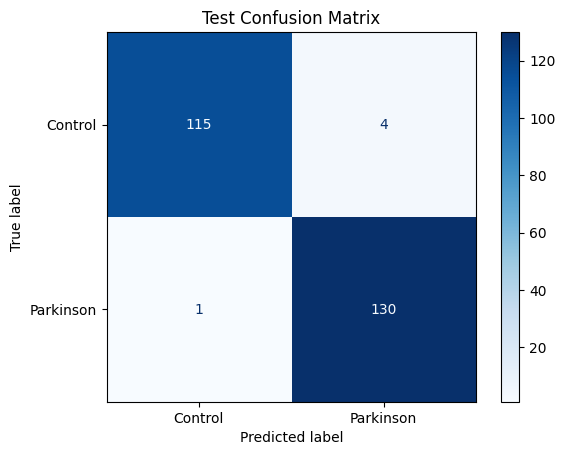

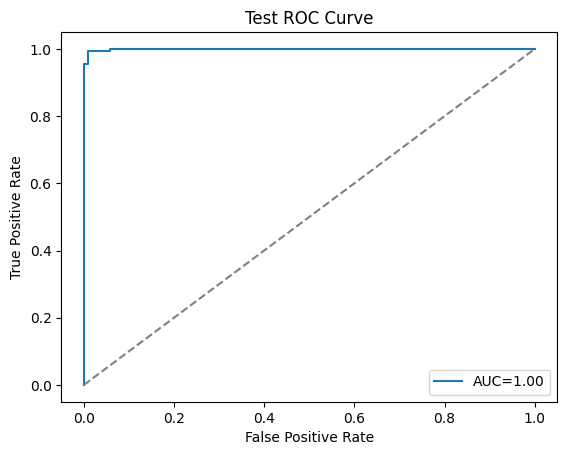

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Test DataLoader (no augment!)
test_loader = DataLoader(
    PDVoiceDataset(test_ds, augment=None),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

backbone.eval()
classifier.eval()
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for feats, y in test_loader:
        feats, y = feats.to(device), y.to(device)
        logits = classifier(backbone(feats))
        probs = torch.softmax(logits, 1)[:, 1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(y.cpu().numpy())
all_probs  = np.concatenate(all_probs)
all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Metrics & Report
print(classification_report(all_labels, all_preds, target_names=["Control", "Parkinson"]))
print(f"ROC AUC: {roc_auc_score(all_labels, all_probs):.4f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds, display_labels=["Control", "Parkinson"], cmap="Blues"
)
plt.title("Test Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(all_labels, all_probs):.2f}")
plt.plot([0,1],[0,1],'--',c='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()
